## Introduction to animation ! 

### This code reads in data recorded by a temperature and humidity sensor, 
### then creates several different kinds of animations of the same data. 

### (1) read data in and plot it. 
### (2) animate a dot sliding along the data.
### (3) animate a dot moving through 2-D "phase" space (Temp-humidity).
### (4) animate a throbbing dot.
### (5) generate soundtrack.
### (6) add to animation to make a Movie ! (a data talkie). 

##### made by Ben Holtzman, with essential contributions from Cian Wilson, Owen Evans, Douglas Repetto, Onur Yildirim. 

In [1]:
# all the packages and modules we'll need for now. will import more later. 
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# this tells the notebook kernel to use the graphics engine in the OS
%matplotlib auto 
# %matplotlib notebook
# the animation modules from matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches

import sys
sys.path.append('./modules/')
from importlib import reload

# iPython commands that start with % are called "magics"
# this tells the notebook to show us graphics inline
# this is only meaningful in iPython Notebook, nothing outside iPNb

# this is commented out, because the animation does not work inline-- all figures will pop up windows. 
%matplotlib inline

Using matplotlib backend: TkAgg


## =================================================
## (1) Read in and plot the raw data

In [3]:
# READ IN THE DATA FILE ! ! !

# READ IN THE DATA FILE ! ! !
#datafilename = '../0_data_examples/breathalyzer/BA_ben_1.pkl'
datafilename = '../0_data_examples/breathalyzer/120s_wurfigurinitout.pkl'
breath = pd.read_pickle(datafilename) # np.loadtxt(datafilename)
print(breath[0:5])
time = np.array(breath.time_s)
p1 = temp_C = np.array(breath.temp_C)
p2 = humidity = np.array(breath.hum)

h_over_T = humidity/temp_C;
dTdt = np.diff(temp_C);
dHdt = np.diff(humidity);
dTdt_norm = dTdt/max(abs(dTdt))*100
dHdt_norm = dHdt/max(abs(dHdt))*100

dt =  time[-1]-time[-2]
print(dt)
print(len(time))
print(dt*len(time))
print(time[-1])

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1

time_diff = time+dt/2
time_diff = time_diff[0:-1]

      hum  temp_C  time_s
0  18.882   26.95  0.0000
1  18.883   26.96  0.3755
2  18.884   26.97  0.7509
3  18.884   26.97  1.1264
4  18.884   26.97  1.5021
0.3813999999999993
317
120.90379999999978
120.2081


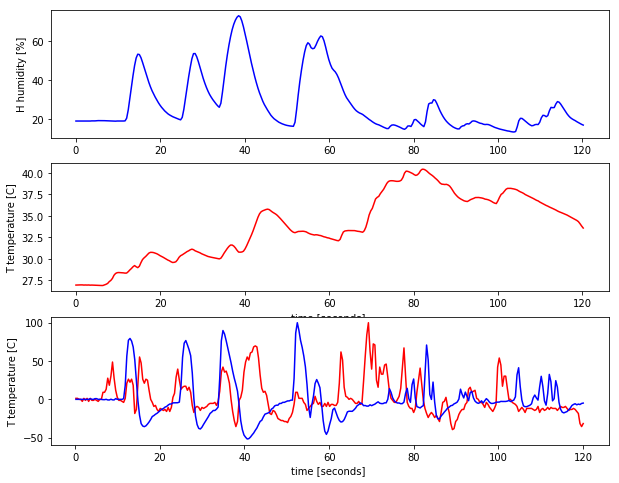

In [4]:
# PLOT THE DATA AS CURVES... 
fig = plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(time,humidity,'b-')
#plt.xlabel('time')
plt.ylabel('H humidity [%]')

plt.subplot(3,1,2)
plt.plot(time,temp_C,'r-')
plt.xlabel('time [seconds] ')
plt.ylabel('T temperature [C]')

plt.subplot(3,1,3)
plt.plot(time_diff,dTdt_norm,'r-')
plt.plot(time_diff,dHdt_norm,'b-')
plt.xlabel('time [seconds] ')
plt.ylabel('T temperature [C]')

plt.show()

# ============================================
## (2) Animate a dot moving along the data in time... 

In [5]:
# this is a foreshadowing of the next stage, 
# where we will make classes that are the heart of object-oriented programming
# but for now we won't take advantage of the power of OOP, for the sake of transparency ! 
# as we will only have one "instance" of each kind of animation. 
# The next notebook will introduce OOP. 

# this is a little class that lets the "patches" object not stretch the dots... 
# it won't make any sense for now, but later it hopefully will ! 
# i found it somewhere but forgot to record where-- 
# but i think there is a probably a simpler way to do this now ! 
# maybe by rescaling the data to [0,1] and then writing the axis labels as the real values ? 

class GraphDist() :
    def __init__(self, size, ax, x=True) :
        self.size = size
        self.ax = ax
        self.x = x

    @property
    def dist_real(self) :
        x0, y0 = self.ax.transAxes.transform((0, 0)) # lower left in pixels
        x1, y1 = self.ax.transAxes.transform((1, 1)) # upper right in pixes
        value = x1 - x0 if self.x else y1 - y0
        return value

    @property
    def dist_abs(self) :
        bounds = self.ax.get_xlim() if self.x else self.ax.get_ylim()
        return bounds[0] - bounds[1]

    @property
    def value(self) :
        return (self.size / self.dist_real) * self.dist_abs

    def __mul__(self, obj) :
        return self.value * obj

num frames = 317
movie_dur = 20.0
frame_interval = 0.06309148264984227
frames per sec = 15.850000000000001


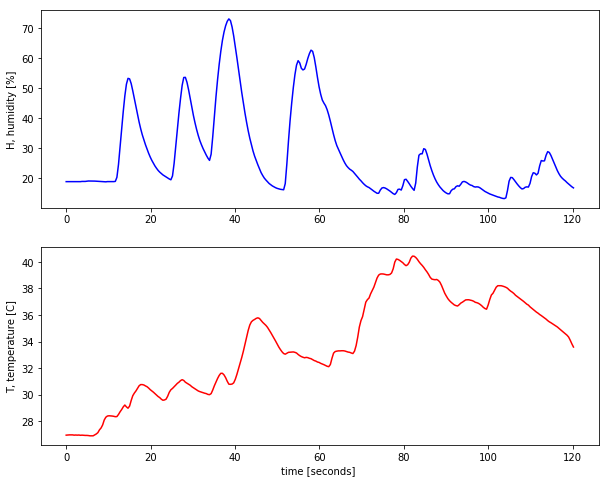

In [6]:
# a nice tutorial for simple animation: 
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# ==================================================
# initialize the objects
fig = plt.figure(figsize=(10,8))
axes1 = plt.subplot(2,1,1) 
axes2 = plt.subplot(2,1,2) 

axes1.plot(time,humidity,'b-')
axes1.set_ylabel('H, humidity [%]')

axes2.plot(time,temp_C,'r-')
axes2.set_xlabel('time [seconds] ')
axes2.set_ylabel('T, temperature [C]')

rad_pix = 20

# here we are using the class above to scale the ellipse axes to the data so they are round dots. 
dot1_width = GraphDist(rad_pix, axes1, True)
dot1_height = GraphDist(rad_pix, axes1, False)
dot2_width = GraphDist(rad_pix, axes2, True)
dot2_height = GraphDist(rad_pix, axes2, False)


patch1 = patches.Ellipse((time[0], humidity[0]), dot1_width, dot1_height, fc='red')
patch2 = patches.Ellipse((time[0], temp_C[0]), dot2_width, dot2_height, fc='blue')

#patch2 = patches.Circle((time[0], temp_C[0]),0.1, fc='blue')
#ax1.add_patch(patches.Circle((0.5, 0.5),radius_norm,facecolor="red")) 

# patch1. then hit [tab] to see what properties the patches.Ellipse have !

# older ways that didn't work: 
#ax.add_artist(Ellipse((1, 3), width, height))
#patches.Circle((0.5, 0.5),radius_norm,facecolor="red"

# ===================================================
# initialize what will move in the animation
def init():
    patch1.center = (time[0], humidity[0])
    patch2.center = (time[0], temp_C[0])
    axes1.add_patch(patch1)
    axes2.add_patch(patch2)
    return patch1, patch2,

# ===================================================
# define what will move in the animation
# (note that this function is not OOP ! two dots moving in here !)
def animate(i): # is this (i) needed for the animate function 
    x , y = time[i], humidity[i]
    patch1.center = (x , y)
    axes1.add_patch(patch1)
    
    x , y = time[i], temp_C[i]
    patch2.center = (x , y)
    axes2.add_patch(patch2)
    
    return patch1,patch2,

# the comma at the end here is important ! i forget why ! 

# ====================================================
# RUN the animation ! 

# the number of movie frames-- in this case, simply the number of data points. 
time_ind_vec = np.arange(0, len(time)-1)

# time interval between frames in milliseconds. 
# figure out the movie duration and frame interval
n_frames = len(time)
print('num frames = ' + str(n_frames))
movie_dur = 20.0 # in seconds
print('movie_dur = ' + str(movie_dur))

frame_interval_sec = interv = movie_dur/n_frames
print('frame_interval = ' + str(frame_interval_sec))
fps_ideal = 1./frame_interval_sec
print('frames per sec = ' + str(fps_ideal))


plt.show()
#plt.ioff()

# from the example: ani = animation.FuncAnimation(fig, notes_time, np.arange(1, len(nums)), init_func=init,
#                             interval=400, blit=True)
#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)

In [7]:
# RUN and save the animation: 
ani = animation.FuncAnimation(fig, animate, time_ind_vec, interval=interv*1000, init_func=init) #frames=200,blit=True)
moviename = 'slidingDotsxTime1.avi'
ani.save(moviename)

ValueError: Invalid file object: <_io.BufferedReader name=86>

# ============================================
## (3) One dot sliding around 2D space 

num frames = 316
movie_dur = 20.0
frame_interval = 0.06329113924050633
frames per sec = 15.799999999999999


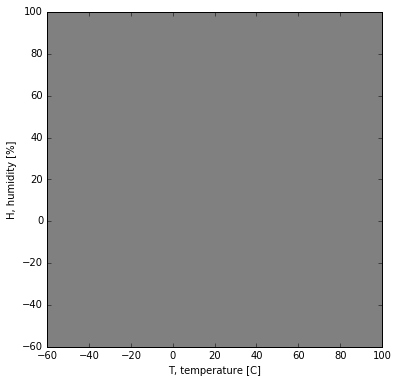

In [115]:
# a nice tutorial for simple animation: 
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# ==================================================
# initialize the objects
fig = plt.figure(figsize=(6,6))
axes1 = plt.subplot(1,1,1) 

#axes1.plot(dTdt_norm,dHdt_norm,'b-')
axes1.set_xlabel('T, temperature [C]')
axes1.set_ylabel('H, humidity [%]')

axes1.set_ylim((-60,100))
axes1.set_xlim((-60,100))
axes1.set_axis_bgcolor('grey')
rad_pix = 20

# here we are using the class above to scale the ellipse axes to the data so they are round dots. 
dot1_width = GraphDist(rad_pix, axes1, True)
dot1_height = GraphDist(rad_pix, axes1, False)

patch1 = patches.Ellipse((dTdt_norm[0], dHdt_norm[0]), dot1_width, dot1_height)#, fc='red')
#streak = plt.(dTdt_norm[0],dHdt_norm[0])
line1, = axes1.plot([], [], lw=2)
line2, = axes1.plot([], [], lw=2)
line3, = axes1.plot([], [], lw=2)
line4, = axes1.plot([], [], lw=2)
line5, = axes1.plot([], [], lw=2)
line6, = axes1.plot([], [], lw=2)
line7, = axes1.plot([], [], lw=2)
line8, = axes1.plot([], [], lw=2)
line9, = axes1.plot([], [], lw=2)
line10, = axes1.plot([], [], lw=2)


# ===================================================
# initialize what will move in the animation
def init():
    patch1.center = (dTdt_norm[0], dHdt_norm[0])
    patch1.set_facecolor(color=color_getter(temp_C[0]))
    axes1.add_patch(patch1)
    #axes1.plot(dTdt_norm[0],dHdt_norm[0],'k')
    line.set_data([], [])
    return patch1

# ===================================================
# define what will move in the animation
def animate(i): # is this (i) needed for the animate function 
    x , y = dTdt_norm[i], dHdt_norm[i]
    patch1.center = (x , y)
    patch1.set_facecolor(color=color_getter(temp_C[i]))
    axes1.add_patch(patch1)  
    if i > 10:
        #print(i)
        #axes1.plot(dTdt_norm[i-5:i],dHdt_norm[i-5:i])
        line1.set_data(dTdt_norm[i-1:i],dHdt_norm[i-1:i])
        line1.set_color(color=color_getter(temp_C[i]))
        
        line2.set_data(dTdt_norm[i-2:i],dHdt_norm[i-2:i])
        line2.set_color(color=color_getter(temp_C[i-1]))
        
        line3.set_data(dTdt_norm[i-3:i],dHdt_norm[i-3:i])
        line3.set_color(color=color_getter(temp_C[i-2]))
        
        line4.set_data(dTdt_norm[i-4:i],dHdt_norm[i-4:i])
        line4.set_color(color=color_getter(temp_C[i-3]))
        
        line5.set_data(dTdt_norm[i-5:i],dHdt_norm[i-5:i])
        line5.set_color(color=color_getter(temp_C[i-4]))
        
        line6.set_data(dTdt_norm[i-6:i],dHdt_norm[i-6:i])
        line6.set_color(color=color_getter(temp_C[i-5]))
        
        line7.set_data(dTdt_norm[i-7:i],dHdt_norm[i-7:i])
        line7.set_color(color=color_getter(temp_C[i-6]))
        
        line8.set_data(dTdt_norm[i-8:i],dHdt_norm[i-8:i])
        line8.set_color(color=color_getter(temp_C[i-7]))
        
        line9.set_data(dTdt_norm[i-9:i],dHdt_norm[i-9:i])
        line9.set_color(color=color_getter(temp_C[i-8]))
    else:
        #print(i)
        #axes1.plot(dTdt_norm[0:i],dHdt_norm[0:i])
        line.set_data(dTdt_norm[0:i],dHdt_norm[0:i])
        line.set_color(color=color_getter(temp_C[i]))
    return patch1, 

def color_getter(temp_val):
    #cmap = plt.get_cmap('inferno')
    cmap = cm.hot
    color_vec = np.linspace(0,1,num_vals)
    color_ind = np.interp(temp_val,temp_vec,color_vec)
    dot_col_T = cmap(color_ind)
    return dot_col_T

# ====================================================
# RUN the animation ! 

# the number of movie frames-- in this case, simply the number of data points. 
time_ind_vec = np.arange(0, len(time_diff)-1)

# time interval between frames in milliseconds. 
# 30 fps would be 1000/30*dt where dt is the time interval in the original data
# this number determines the speed of the movie.. larger number slows it down; 
# figure out the movie duration and frame interval
n_frames = len(dHdt_norm)
print('num frames = ' + str(n_frames))
movie_dur = 20.0 # in seconds
print('movie_dur = ' + str(movie_dur))

frame_interval_sec = movie_dur/n_frames
print('frame_interval = ' + str(frame_interval_sec))
fps_ideal = 1./frame_interval_sec
print('frames per sec = ' + str(fps_ideal))



plt.show()

num frames = 317
movie_dur = 21.0
frame_interval = 0.06624605678233439
frames per sec = 15.095238095238095


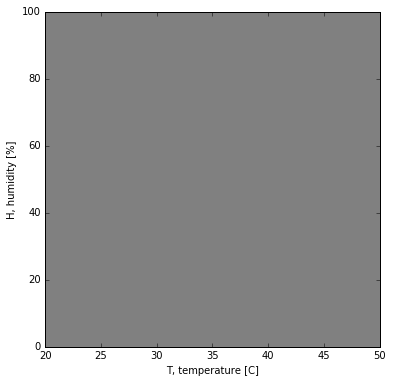

In [131]:
# a nice tutorial for simple animation: 
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# ==================================================
# initialize the objects
fig = plt.figure(figsize=(6,6))
axes1 = plt.subplot(1,1,1) 

#axes1.plot(dTdt_norm,dHdt_norm,'b-')
axes1.set_xlabel('T, temperature [C]')
axes1.set_ylabel('H, humidity [%]')

axes1.set_ylim((0,100))
axes1.set_xlim((20,50))
axes1.set_axis_bgcolor('grey')
rad_pix = 20

# here we are using the class above to scale the ellipse axes to the data so they are round dots. 
dot1_width = GraphDist(rad_pix, axes1, True)
dot1_height = GraphDist(rad_pix, axes1, False)

patch1 = patches.Ellipse((temp_C[0], dHdt_norm[0]), dot1_width, dot1_height)#, fc='red')
#streak = plt.(dTdt_norm[0],dHdt_norm[0])
line1, = axes1.plot([], [], lw=2)
line2, = axes1.plot([], [], lw=2)
line3, = axes1.plot([], [], lw=2)
line4, = axes1.plot([], [], lw=2)
line5, = axes1.plot([], [], lw=2)
line6, = axes1.plot([], [], lw=2)
line7, = axes1.plot([], [], lw=2)
line8, = axes1.plot([], [], lw=2)
line9, = axes1.plot([], [], lw=2)
line10, = axes1.plot([], [], lw=2)


# ===================================================
# initialize what will move in the animation
def init():
    patch1.center = (temp_C[0], humidity[0])
    patch1.set_facecolor(color=color_getter(temp_C[0]))
    axes1.add_patch(patch1)
    #axes1.plot(dTdt_norm[0],dHdt_norm[0],'k')
    line.set_data([], [])
    return patch1

# ===================================================
# define what will move in the animation
def animate(i): # is this (i) needed for the animate function 
    x , y = temp_C[i], humidity[i]
    patch1.center = (x , y)
    patch1.set_facecolor(color=color_getter(temp_C[i]))
    axes1.add_patch(patch1)  
    if i > 10:
        #print(i)
        #axes1.plot(dTdt_norm[i-5:i],dHdt_norm[i-5:i])
        line1.set_data(temp_C[i-1:i],humidity[i-1:i])
        line1.set_color(color=color_getter(temp_C[i]))
        
        line2.set_data(temp_C[i-2:i],humidity[i-2:i])
        line2.set_color(color=color_getter(temp_C[i-1]))
        
        line3.set_data(temp_C[i-3:i],humidity[i-3:i])
        line3.set_color(color=color_getter(temp_C[i-2]))
        
        line4.set_data(temp_C[i-4:i],humidity[i-4:i])
        line4.set_color(color=color_getter(temp_C[i-3]))
        
        line5.set_data(temp_C[i-5:i],humidity[i-5:i])
        line5.set_color(color=color_getter(temp_C[i-4]))
        
        line6.set_data(temp_C[i-6:i],humidity[i-6:i])
        line6.set_color(color=color_getter(temp_C[i-5]))
        
        line7.set_data(temp_C[i-7:i],humidity[i-7:i])
        line7.set_color(color=color_getter(temp_C[i-6]))
        
        line8.set_data(temp_C[i-8:i],humidity[i-8:i])
        line8.set_color(color=color_getter(temp_C[i-7]))
        
        line9.set_data(temp_C[i-9:i],humidity[i-9:i])
        line9.set_color(color=color_getter(temp_C[i-8]))
    else:
        #print(i)
        #axes1.plot(dTdt_norm[0:i],dHdt_norm[0:i])
        line.set_data(temp_C[0:i],humidity[0:i])
        line.set_color(color=color_getter(temp_C[i]))
    return patch1, 

def color_getter(temp_val):
    #cmap = plt.get_cmap('inferno')
    cmap = cm.hot
    color_vec = np.linspace(0,1,num_vals)
    color_ind = np.interp(temp_val,temp_vec,color_vec)
    dot_col_T = cmap(color_ind)
    return dot_col_T

# ====================================================
# RUN the animation ! 

# the number of movie frames-- in this case, simply the number of data points. 
time_ind_vec = np.arange(0, len(time)-1)

# time interval between frames in milliseconds. 
# 30 fps would be 1000/30*dt where dt is the time interval in the original data
# this number determines the speed of the movie.. larger number slows it down; 
# figure out the movie duration and frame interval
n_frames = len(humidity)
print('num frames = ' + str(n_frames))
movie_dur = 21.0 # in seconds
print('movie_dur = ' + str(movie_dur))

frame_interval_sec = movie_dur/n_frames
print('frame_interval = ' + str(frame_interval_sec))
fps_ideal = 1./frame_interval_sec
print('frames per sec = ' + str(fps_ideal))



plt.show()

In [140]:
line1

In [132]:
# RUN (but don't write out to file) the animation: 
ani = animation.FuncAnimation(fig, animate, time_ind_vec, interval=interv*1000, init_func=init)# ,blit=True)
moviename = 'slidingDotsPhaseSpc_T_H_norm.avi'
ani.save(moviename)

# ============================================
## (4) Throbbing dot

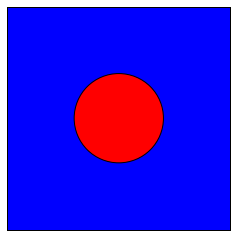

In [10]:
# Create a square with a circle in it.. the circle diameter changes with humidity 
# (tracking the flux of hot wet air)
# and the color changes with the temperature ! 

# http://matthiaseisen.com/pp/patterns/p0203/
# http://matthiaseisen.com/matplotlib/shapes/circle/
# https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html
#%matplotlib inline
import matplotlib.patches as patches

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')

# (0) plot a filled square with a filled circle in it...
# patches.Rectangle((x,y of the lower left corner),width,height, etc...)
ax1.add_patch(patches.Rectangle((0.0, 0.0),1.0,1.0,facecolor="blue"))

radius_norm = 0.2  # radius normalized, scaled to size of box
ax1.add_patch(patches.Circle((0.5, 0.5),radius_norm,facecolor="red")) 
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

rad_val = 0.12801301301301304
dot_col_T = (0.30926594541530605, 0.0, 0.0, 1.0)


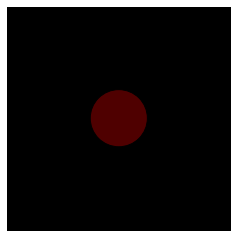

In [11]:
# MAPPING THE PHYSICAL VALUES TO DOT PARAMETERS...
from matplotlib import cm

ind = 25
num_vals = 10

# =====================
# MAP HUMIDITY TO RADIUS
humid_vec = np.linspace(np.min(humidity),np.max(humidity),num_vals)

def scale_radius(humidity_val):
    min_rad = 0.1
    max_rad = 0.4
    radius_vec = np.linspace(min_rad,max_rad,num_vals)
    rad_val = np.interp(humidity_val,humid_vec,radius_vec)
    return rad_val

rad_val_0 = scale_radius(humidity[ind])
print('rad_val = ' + str(rad_val_0))

# =====================
# MAP TEMPERATURE TO COLOR
temp_vec = np.linspace(np.min(temp_C),np.max(temp_C),num_vals)
def color_getter(temp_val):
    #cmap = plt.get_cmap('inferno')
    cmap = cm.hot
    color_vec = np.linspace(0,1,num_vals)
    color_ind = np.interp(temp_val,temp_vec,color_vec)
    dot_col_T = cmap(color_ind)
    return dot_col_T

col0 = color_getter(temp_C[ind])
print('dot_col_T = ' + str(col0) )

# ======================
# REPLOT THE CIRCLE WITH SINGLE VALUES OF THE DATA ! 
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')

# (0) plot a filled square with a filled circle in it...
# patches.Rectangle((x,y,lower left corner),width,height)
ax1.add_patch(patches.Rectangle((0.0, 0.0),1.0,1.0,facecolor="black"))

ax1.add_patch(patches.Circle((0.5, 0.5),rad_val_0,facecolor = col0 )) 
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

plt.show()


num frames = 317
movie_dur = 20.0
frame_interval = 0.06309148264984227
frames per sec = 15.850000000000001


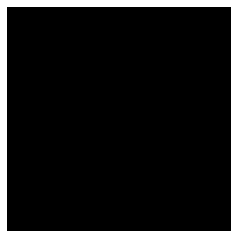

In [12]:
# ANIMATE 
#%matplotlib auto

# flag to determine whether movie gets viewed (0) or recorded (1), not both. 
# view_or_write = 1
# to save, you must first install ffmpeg (and then restart the notebook engine)

fig2 = plt.figure()

ax2 = fig2.add_subplot(111, aspect='equal')
bg_square = patches.Rectangle((0.0, 0.0),1.0,1.0,facecolor="black")
ax2.add_patch(bg_square)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

circle = patches.Circle((0.5, 0.5),0.2,facecolor="black")

# ===================================================
# initialize what will move in the animation
def init():
    col = []
    col = color_getter(temp_C[0])
    rad = scale_radius(humidity[0])
    circle.radius = rad
    circle.set_color(col)
    ax2.add_artist(circle)
    return circle,

# ===================================================
# define what will move in the animation
def animate(i): # is this (i) needed for the animate function ? 
    col = []
    col = color_getter(temp_C[i])
    rad = scale_radius(humidity[i])
    #print(rad)
    circle.radius = rad
    circle.set_color(col)
    ax2.add_artist(circle)   
    return circle,


# the number of movie frames-- in this case, simply the number of data points. 
time_ind_vec = np.arange(0, len(time)-1)

# figure out the movie duration and frame interval
n_frames = len(humidity)
print('num frames = ' + str(n_frames))
movie_dur = 20.0 # in seconds
print('movie_dur = ' + str(movie_dur))

frame_interval_sec = movie_dur/n_frames
print('frame_interval = ' + str(frame_interval_sec))
fps_ideal = 1./frame_interval_sec
print('frames per sec = ' + str(fps_ideal))

#anim = animation.FuncAnimation(fig2, animate, init_func=init, frames=len(humidity), interval=interv) 
                                #,repeat=False) 
#                               blit=True)

# if view_or_write==0:
#     plt.show()
# elif view_or_write==1:

#anim.save(movie_name, fps=fps_ideal, extra_args=['-vcodec', 'h264','-pix_fmt', 'yuv420p'])
# check exact duration of movie with >> ffprobe [moviename]


In [13]:
ani = animation.FuncAnimation(fig2, animate, time_ind_vec, interval=interv*1000, init_func=init)# ,blit=True)
moviename = 'throbbingDot1.avi'
ani.save(moviename,extra_args=['-vcodec', 'h264','-pix_fmt', 'yuv420p']) # extra_args=['-vcodec', 'h264','-pix_fmt', 'yuv420p']

In [56]:
# make a class for that circle defined by the two params, 
# then a list or array of each persons breath, associated with their data. 
# and add them to the array
# then in animate it will loop through the list of the circle class instances (structure: array) 
# then a loop for each circle in circle_array, do this.. 
# then the same thing inside animate... 

# ===================================
# (5) AND NOW FOR THE SOUND
# ===================================
### 1) go back to the sound making methods and make one track for humidity and one for temperature...
### 2) put them together ! 

In [133]:
# our modules: 
import sys
sys.path.append('../2_modules/')
import notepicker
import makeDataChord_v2 as mDc
import writeCmixSco_GRAN_v2 as wRT_gran
from subprocess import Popen
import subprocess as sp
import os
import librosa
print(librosa.__version__)
import librosa.display

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

0.5.0
CMIX found.


In [15]:
# TEMPERATURE: 

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1 = temp_C

# the gransynth instrument ! 
# http://rtcmix.org/reference/instruments/GRANSYNTH.php

# FREQUENCIES
# in linear octaves
root_freq = 7.0 # what is the lowest value it can have?
peak_freq = 8.6
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

# AMPLITUDE
# absolute amplitude (16-bit, 0-32768)
amp_range = [2000,15000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)

# PITCHJITTER
# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).
pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)

#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'Temp_gransynth_LeftCh'
tones_dict['dur_sound'] = 20.0

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

dur = 20.0

317
Amplitude is time varying (p-field)
317
Pitchjitter is time varying (p-field)
CMIX found.
rtoutput("Temp_gransynth_LeftCh.wav")

RTcmix score created.


In [16]:
#play RTcmix score and create a wave file
#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav


CMIX < Temp_gransynth_LeftCh.sco

hopefully i just wrote your sound file (Temp_gransynth_LeftCh.wav); is it here?
Temp_gransynth_LeftCh.wav         test_noRhythm_Temp.wav
lern_GRANSYNTH_v1_pitchjitVAR.wav


(20, 2048)

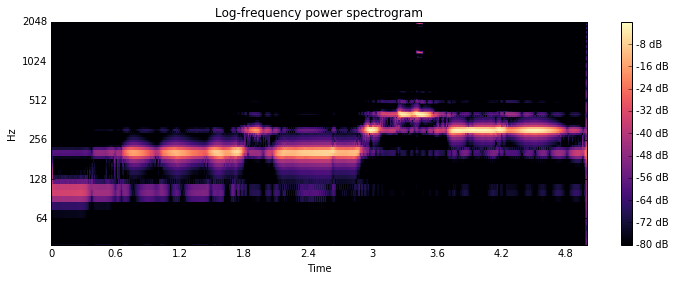

In [17]:
# PLOT THE SPECTROGRAM
filename = tones_dict['base_name'] + '.wav'

y, sr = librosa.load(filename)
y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

plt.figure(figsize=(12,4))
librosa.display.specshow(y_db, sr=sr, hop_length=128, x_axis='time', y_axis='log') #y_axis='log'
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.ylim([20,2048])

In [18]:
# HUMIDITY: 

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1 = humidity

# the gransynth instrument ! 
# http://rtcmix.org/reference/instruments/GRANSYNTH.php

# FREQUENCIES
# in linear octaves
root_freq = 6.0 # what is the lowest value it can have?
peak_freq = 7.5
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

# AMPLITUDE
# absolute amplitude (16-bit, 0-32768)
amp_range = [7000,18000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)

# PITCHJITTER
# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).
pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)

#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'Humidity_gransynth_RightCh'
tones_dict['dur_sound'] = 20.0

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

dur = 20.0

317
Amplitude is time varying (p-field)
317
Pitchjitter is time varying (p-field)
CMIX found.
rtoutput("Humidity_gransynth_RightCh.wav")

RTcmix score created.


In [19]:
#play RTcmix score and create a wave file
#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav


CMIX < Humidity_gransynth_RightCh.sco

hopefully i just wrote your sound file (Humidity_gransynth_RightCh.wav); is it here?
Humidity_gransynth_RightCh.wav    lern_GRANSYNTH_v1_pitchjitVAR.wav
Temp_gransynth_LeftCh.wav         test_noRhythm_Temp.wav


(20, 2048)

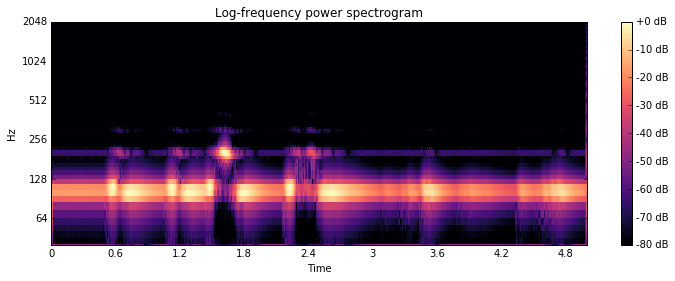

In [20]:
# PLOT THE SPECTROGRAM

filename = tones_dict['base_name'] + '.wav'

y, sr = librosa.load(filename)
y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

plt.figure(figsize=(12,4))
librosa.display.specshow(y_db, sr=sr, hop_length=128, x_axis='time', y_axis='log') #y_axis='log'
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.ylim([20,2048])

# ============================================
## (6) Make the movie by putting the sound and animation together ! 

In [134]:
!ls

Breathalyzer_v1.avi                   s04_DataDrivenRTcmix.ipynb
Humidity_gransynth_RightCh.sco        s05_GranSynth_RTcmix.ipynb
Temp_gransynth_LeftCh.sco             s06_Animation1_Breathalyzer.ipynb
humidity_GRANSYNTH_v1_pitchjitVAR.sco slidingDotsPhaseSpc.avi
humidity_GRANSYNTH_v1_pitchjitVAR.wav slidingDotsPhaseSpc_T_H_norm.avi
lern_GRANSYNTH_v1_pitchjitVAR.sco     slidingDotsPhaseSpc_diff.avi
s00_make_simple_sounds.ipynb          slidingDotsPhaseSpc_diff_norm.avi
s00_make_simple_sounds.py             slidingDotsxTime1.avi
s01_DirectSonification.ipynb          test_noRhythm1.sco
s01_DirectSonification.py             throbbingDot1.avi
s03_IntroPitchesnScales.ipynb


In [138]:
# GENERATE THE MOVIE ! 
anim_name_in = 'slidingDotsPhaseSpc_T_H_norm.avi'

# sound_name_left = '../3_output_nogit/test_gotRhythm1.wav'
# sound_name_right = '../3_output_nogit/test_gotRhythm1.wav'
sound_name_left = '../3_output_nogit/humidity_gotRhythm_vid.wav'
sound_name_right = '../3_output_nogit/test_noRhythm_Temp_rapid.wav'

stereo_sound_name = 'stereo.wav'

movie_snd_name = 'Breathalyzer_phase_space_TH_gotrhythm.avi'

#make single stereo track from two mono tracks -- 
# but this route is less preferable than generating one stereo track from RTcmix directly ! 
# https://trac.ffmpeg.org/wiki/AudioChannelManipulation
# ffmpeg -i left.mp3 -i right.mp3 -filter_complex "[0:a][1:a]join=inputs=2:channel_layout=stereo[a]" -map "[a]" output.mp3
#ffmpeg -i Temp_gransynth_LeftCh.wav -i Humidity_gransynth_RightCh.wav -filter_complex "[0:a][1:a]join=inputs=2:channel_layout=stereo[a]" -map "[a]" stereo.mp3
#ffmpeg -i INPUT1 -i INPUT2 -filter_complex join=inputs=2 OUTPUT
#ffmpeg -i Humidity_gransynth_RightCh.wav -i Temp_gransynth_LeftCh.wav -filter_complex join=inputs=2 stereo.mp3

# Make single stereo track from two mono tracks -- 
run_ffmpeg_stereo_cmd = 'ffmpeg -i ' + sound_name_left + ' -i ' + sound_name_right + ' -filter_complex join=inputs=2 ' + stereo_sound_name
make_stereo = sp.Popen(run_ffmpeg_stereo_cmd, shell=True) 
make_stereo.wait()

# add the sound file to the movie file ! 
run_ffmpeg_movie_cmd = 'ffmpeg -i ' + stereo_sound_name + ' -i ' + anim_name_in + ' ' + movie_snd_name
make_movie = sp.Popen(run_ffmpeg_movie_cmd, shell=True) 
make_movie.wait()

print("And now did i just write your movie; is it here?")
! ls *.avi
print("BUT beware ! it might take a while to write ! ")

And now did i just write your movie; is it here?
Breathalyzer_phase_space_TH.avi
Breathalyzer_phase_space_TH_gotrhythm.avi
Breathalyzer_phase_space_TH_norhythm.avi
Breathalyzer_v1.avi
slidingDotsPhaseSpc.avi
slidingDotsPhaseSpc_T_H_norm.avi
slidingDotsPhaseSpc_diff.avi
slidingDotsPhaseSpc_diff_norm.avi
slidingDotsxTime1.avi
throbbingDot1.avi
BUT beware ! it might take a while to write ! 


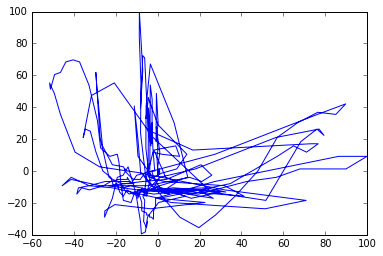

In [139]:
plt.plot(dHdt_norm,dTdt_norm)